## Data integration

Combining data from different sources to provide a unified view or dataset.


## Human population
UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020)


In [32]:
import netCDF4 as nc
import pandas as pd
import numpy as np

# Open the netCDF file for population density
file_path = "G:/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_totpop_2pt5_min_nc/gpw_v4_population_density_adjusted_rev11_2pt5_min.nc"
dataset = nc.Dataset(file_path, 'r')

# Extract variables
lon = dataset['longitude'][:]  # Shape: (8640,)
lat = dataset['latitude'][:]  # Shape: (4320,)
# Assuming 'raster' dimension represents time or scenarios, adjust as needed
time_slices = dataset.dimensions['raster'].size  # Assuming this represents years or time slices
population_density = dataset['UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'][:]

# Morocco's bounding box coordinates
morocco_min_lon, morocco_min_lat, morocco_max_lon, morocco_max_lat = -17.10464433, 20.76691315, -1.03199947, 35.92651915

# Filter lon and lat based on Morocco's bounding box
morocco_lon_indexes = np.where((lon >= morocco_min_lon) & (lon <= morocco_max_lon))[0]
morocco_lat_indexes = np.where((lat >= morocco_min_lat) & (lat <= morocco_max_lat))[0]

# Initialize DataFrame to store data
morocco_population_data = pd.DataFrame()

# Iterate over each time slice
for t in range(time_slices):
    data_list = []
    for i in morocco_lat_indexes:
        for j in morocco_lon_indexes:
            latitude = lat[i]
            longitude = lon[j]
            population_density_value = population_density[t, i, j]
            # Append latitude, longitude, and population density to the list
            # Assuming 't' can be mapped to a year or time slice description
            data_list.append([latitude, longitude, t, population_density_value])

    # Convert list to DataFrame
    temp_df = pd.DataFrame(data_list, columns=['Latitude', 'Longitude', 'Raster', 'PopulationDensity'])
    morocco_population_data = pd.concat([morocco_population_data, temp_df], axis=0)

# Show the DataFrame structure
print(morocco_population_data.head())

# Close the dataset
dataset.close()


    Latitude  Longitude  Raster PopulationDensity
0  35.895833 -17.104167       0                --
1  35.895833 -17.062500       0                --
2  35.895833 -17.020833       0                --
3  35.895833 -16.979167       0                --
4  35.895833 -16.937500       0                --


In [10]:
morocco_population_data[(morocco_population_data.Longitude == "-1.229167")& (morocco_population_data.Latitude == "20.770833"	)]

,Latitude,Longitude,TimeSlice,PopulationDensity


In [51]:
# Replace '--' with np.nan
morocco_population_data2=morocco_population_data[morocco_population_data.PopulationDensity!='--']


In [54]:
morocco_population_data2.to_parquet('Data/HumanActivities/morocco_population_data.parquet')

In [93]:
import geopandas as gpd
from shapely.geometry import Point

# Assuming world is already loaded as a GeoDataFrame
world = gpd.read_file("./Data/GeoData/SHP/ne_10m_admin_0_countries_mar.shp")

def filter_points_within_morocco(df):
    """
    Filter rows based on whether their point locations fall within Morocco.

    Args:
    df (pd.DataFrame): A DataFrame containing 'Latitude' and 'Longitude' columns.

    Returns:
    gpd.GeoDataFrame: A GeoDataFrame containing only the rows where points are within Morocco.
    """
    # Ensure the input DataFrame has 'Latitude' and 'Longitude' columns
    if not {'Latitude', 'Longitude'}.issubset(df.columns):
        raise ValueError("DataFrame must contain 'Latitude' and 'Longitude' columns")

    # Convert the DataFrame to a GeoDataFrame, setting the geometry from Latitude and Longitude
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

    # Filter the world GeoDataFrame to include only Morocco
    morocco = world[world['ADMIN'] == 'Morocco'].geometry.iloc[0]

    # Filter rows where geometry is within Morocco
    gdf_within_morocco = gdf[gdf.geometry.within(morocco)]

    return gdf_within_morocco

# Example usage:
# Assuming you have a DataFrame `df` with 'Latitude' and 'Longitude'
# df_within_morocco = filter_points_within_morocco(df)
# print(df_within_morocco)


In [96]:
morocco_population_data3=filter_points_within_morocco(morocco_population_data2).copy()

In [100]:
morocco_population_data3.to_parquet('Data/FinalDataset/morocco_population.parquet')

In [122]:
morocco_population_data3

,Latitude,Longitude,Raster,PopulationDensity,geometry
279,35.895833,-5.479167,0,103.909401,POINT (-5.47917 35.89583)
280,35.895833,-5.437500,0,70.962265,POINT (-5.43750 35.89583)
281,35.895833,-5.395833,0,510.388458,POINT (-5.39583 35.89583)
282,35.895833,-5.354167,0,3198.767822,POINT (-5.35417 35.89583)
283,35.895833,-5.312500,0,3420.86084,POINT (-5.31250 35.89583)
...,...,...,...,...,...
136646,21.145833,-17.020833,19,0.0,POINT (-17.02083 21.14583)
137032,21.104167,-17.020833,19,0.0,POINT (-17.02083 21.10417)
137417,21.062500,-17.062500,19,0.0,POINT (-17.06250 21.06250)
137803,21.020833,-17.062500,19,0.0,POINT (-17.06250 21.02083)


In [120]:
sample_morocco_population_data=morocco_population_data3.sample(1000).copy()

# Convert 'PopulationDensity' to numeric
sample_morocco_population_data['PopulationDensity'] = sample_morocco_population_data['PopulationDensity'].fillna(0)
sample_morocco_population_data['PopulationDensity'] = pd.to_numeric(sample_morocco_population_data['PopulationDensity'], errors='coerce')

# Round 'PopulationDensity' to two decimal places
sample_morocco_population_data['PopulationDensity'] = sample_morocco_population_data['PopulationDensity'].round(3)
sample_morocco_population_data=sample_morocco_population_data[sample_morocco_population_data.PopulationDensity>5]

In [94]:
# sample_morocco_population_data=filter_points_within_morocco(sample_morocco_population_data)

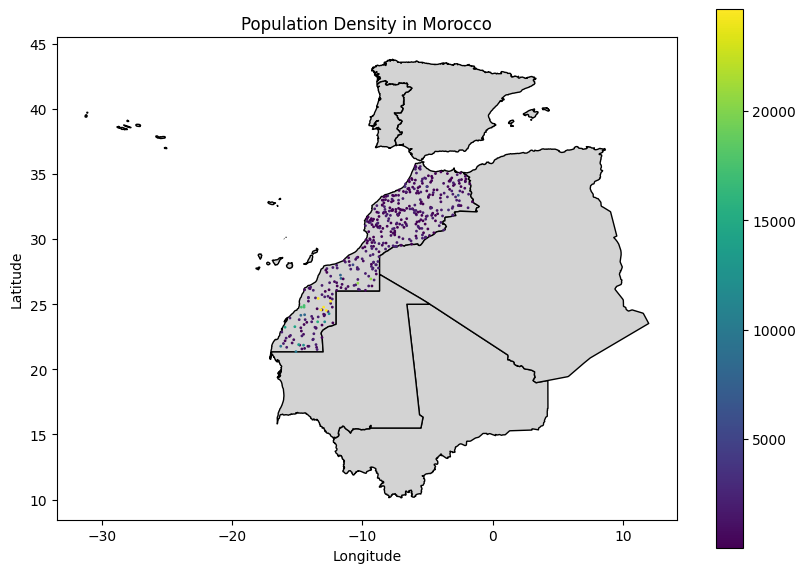

In [121]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt



# Convert DataFrame to GeoDataFrame
gdf_morocco = gpd.GeoDataFrame(
    sample_morocco_population_data, 
    geometry=gpd.points_from_xy(sample_morocco_population_data.Longitude, sample_morocco_population_data.Latitude)
)

# Morocco's bounding box coordinates
morocco_min_lon, morocco_min_lat, morocco_max_lon, morocco_max_lat = -17.10464433, 20.76691315, -1.03199947, 35.92651915

# Read the shapefile for country boundaries
countries_gdf = gpd.read_file("./Data/GeoData/SHP/ne_10m_admin_0_countries_mar.shp")

# Filter for Morocco using the bounding box (this assumes Morocco is within the bounding box)
morocco_boundary = countries_gdf.cx[morocco_min_lon:morocco_max_lon, morocco_min_lat:morocco_max_lat]

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
morocco_boundary.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_morocco.plot(ax=ax, column='PopulationDensity', legend=True, markersize=1, cmap='viridis')

plt.title('Population Density in Morocco')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


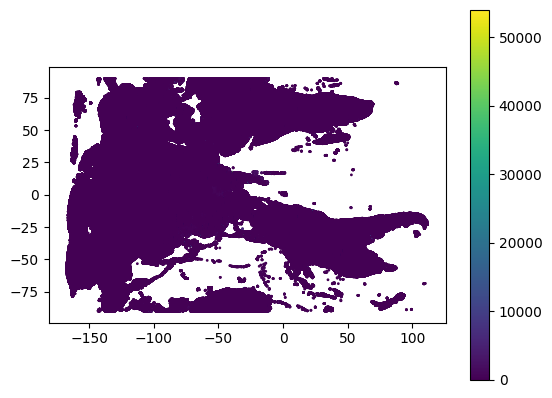

In [55]:
import netCDF4 as nc
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load netCDF file
dataset_path = 'G:/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_totpop_2pt5_min_nc/gpw_v4_population_density_adjusted_rev11_2pt5_min.nc'
dataset = nc.Dataset(dataset_path)

# Read the necessary variables (longitude, latitude, and population density)
lon = dataset['longitude'][:]
lat = dataset['latitude'][:]
# Assuming you are interested in a specific time slice, e.g., the first time slice for population density
population_density = dataset['UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'][0, :, :]

# Flatten the latitude, longitude, and population density arrays
lon_flat = np.repeat(lon, len(lat))
lat_flat = np.tile(lat, len(lon))
pop_density_flat = population_density.flatten()

# Create a DataFrame
df = pd.DataFrame({
    'Longitude': lon_flat,
    'Latitude': lat_flat,
    'PopulationDensity': pop_density_flat
})

# Drop points with missing population density if necessary
df = df[df['PopulationDensity'] >= 0]  # Adjust this condition based on how missing data is represented

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

# Plotting
gdf.plot(column='PopulationDensity', legend=True, markersize=1)  # Adjust markersize as needed

# Close the dataset
dataset.close()
